In [ ]:
import numpy as np
from scipy.special import erfc
import matplotlib.pyplot as plt

# --- 시뮬레이션 파라미터 (문헌 또는 실험값을 사용해야 함) ---

# 확산 시간 (초 단위)
t1_seconds = 170  # seconds
t2_seconds = 150  # seconds

계산된 접합 깊이 (x_j) at C(x,t) = 1.0e+17 cm^-3: 1.55 µm


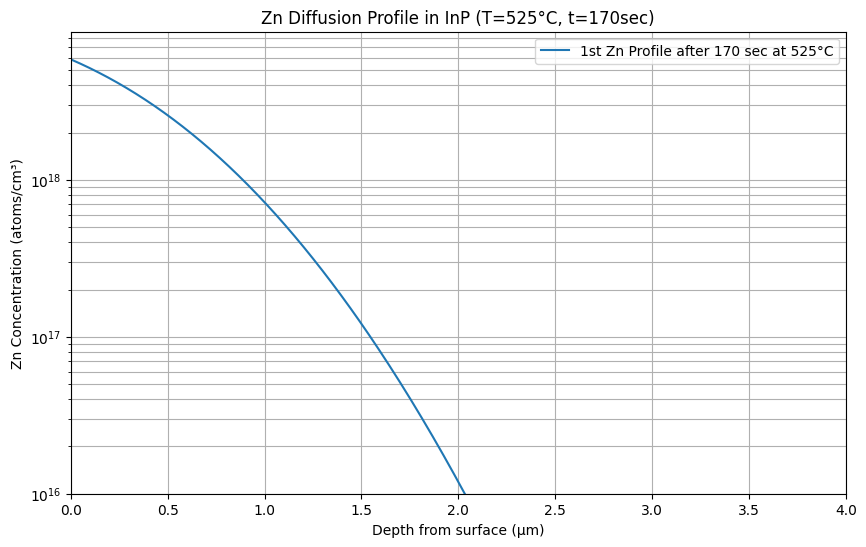


시뮬레이션 조건:
  온도: 525°C (798.15 K)
  표면 농도 (C_s): 5.86e+18 cm^-3
  확산 계수 (D): 1.24e-11 cm^2/s
  총 주입된 도펀트 양 (Q_initial): 3.03e+14 atoms/cm²
  확산 시간: (170 초)
  N형 기판 배경 도핑 농도 (N_B): 1.0e+17 cm^-3


In [ ]:
# k_B = 8.617333262145e-5  # Boltzmann constant in eV/K

# 1. 온도 (섭씨 및 켈빈)
T_celsius = 525  # 섭씨 온도
T_kelvin = T_celsius + 273.15  # 켈빈 온도

# 2. InP 내 Zn의 고용 한계 (Solid Solubility, C_s) at T_celsius
# C_s = 2.5e25 * np.exp(-1.05e5 / k_B * T_kelvin)
C_s_1 = 5.857e18  # atoms/cm^3, at 525 celsius

# 3. InP 내 Zn의 확산 계수 (Diffusion Coefficient, D) at T_celsius
# D = 4.9e-2 * np.exp(-1.52e5 / (k_B * T_kelvin))
D_1 = 1.236e-11 # cm^2/s, at 525 celsius

# 4. 깊이 범위 (시뮬레이션 및 플롯을 위한 범위)
max_depth_um = 4.0  # 최대 깊이 (micrometers)
x_microns = np.linspace(0, max_depth_um, 500)  # 0부터 max_depth_um 까지 500개의 지점
x_cm = x_microns * 1e-4  # microns to cm

# --- 확산 프로파일 계산 (erfc 모델) ---
# C(x,t) = C_s * erfc(x / (2 * sqrt(D*t)))
argument_1 = x_cm / (2 * np.sqrt(D_1 * t1_seconds))
C_xt_1 = C_s_1 * erfc(argument_1)

# 초기 확산으로 도입된 총 도펀트 양 (Q_initial) 계산
Q_initial = (2 / np.sqrt(np.pi)) * C_s_1 * np.sqrt(D_1 * t1_seconds)

# --- P-N 접합 깊이 (Junction Depth, x_j) 계산 (선택 사항) ---
# P+ 영역을 형성하므로, 기판은 N형이라고 가정합니다.
# N형 기판의 배경 도핑 농도 (Background Doping Concentration, N_B)
# 예시: N_B = 1e16 cm^-3
N_B = 1e17  # atoms/cm^3

# C(x_j, t) = N_B 가 되는 x_j를 찾습니다.
# C_xt 배열에서 N_B보다 농도가 높은 마지막 지점을 찾거나, N_B를 처음으로 넘어가는 지점을 찾습니다.
# np.where 사용 시 주의: 정확히 N_B와 일치하는 값이 없을 수 있으므로 근사치를 찾습니다.
junction_indices = np.where(C_xt_1 <= N_B)[0]
if len(junction_indices) > 0:
    x_j_cm_1 = x_cm[junction_indices[0]]
    x_j_um_1 = x_j_cm_1 * 1e4
    print(f"계산된 접합 깊이 (x_j) at C(x,t) = {N_B:.1e} cm^-3: {x_j_um_1:.2f} µm")
else:
    # 모든 깊이에서 농도가 N_B보다 높을 경우 (매우 깊은 확산 또는 얕은 N_B)
    x_j_um_1 = max_depth_um
    print(f"배경 농도 {N_B:.1e} cm^-3 보다 낮은 지점을 찾을 수 없습니다 (최대 깊이 {max_depth_um}µm 이내).")
    print(f"가장 낮은 농도: {C_xt_1[-1]:.2e} cm^-3 at {max_depth_um:.2f} µm")


# --- 결과 플로팅 ---
plt.figure(figsize=(10, 6))
plt.semilogy(x_microns, C_xt_1, label=f'1st Zn Profile after {t1_seconds} sec at {T_celsius}°C')

# 배경 농도 라인 플롯 (선택 사항)
if 'x_j_um' in locals() and x_j_um_1 < max_depth_um : # x_j_um이 정의되어 있고, 최대 깊이보다 작을 때만 표시
    plt.axhline(y=N_B, color='r', linestyle='--', label=f'Background Doping N_B = {N_B:.1e} cm⁻³')
    plt.axvline(x=x_j_um_1, color='g', linestyle=':', label=f'Junction Depth x_j ≈ {x_j_um_1:.2f} µm')

plt.xlabel('Depth from surface (µm)')
plt.ylabel('Zn Concentration (atoms/cm³)')
plt.title(f'Zn Diffusion Profile in InP (T={T_celsius}°C, t={t1_seconds}sec)')
plt.legend()
plt.grid(True, which="both", ls="-")
plt.ylim(bottom=max(1e14, N_B/10), top=C_s_1*1.5) # y축 범위 조절 (N_B 또는 1e14 중 큰 값을 하한으로)
plt.xlim(left=0, right=max_depth_um)
plt.show()

print(f"\n시뮬레이션 조건:")
print(f"  온도: {T_celsius}°C ({T_kelvin:.2f} K)")
print(f"  표면 농도 (C_s): {C_s_1:.2e} cm^-3")
print(f"  확산 계수 (D): {D_1:.2e} cm^2/s")
print(f"  총 주입된 도펀트 양 (Q_initial): {Q_initial:.2e} atoms/cm²")
print(f"  확산 시간: ({t1_seconds} 초)")
if 'N_B' in locals():
    print(f"  N형 기판 배경 도핑 농도 (N_B): {N_B:.1e} cm^-3")


--- Cell 2: 시나리오 1 (Drive-in) 및 시나리오 2 (Continued Source) 실행 중 ---

--- 시나리오 1: No source (t2 = 150 sec) ---
  - 예상 표면 농도: 2.84e+18 atoms/cm³
  - 접합 깊이 (x_j_no, N_B=1e+17): 2.20 µm
  FDM 파라미터:
    dx_cm: 8.02e-07 cm
    dt_seconds: 1.06e-02 s (계산된 최적값 근처)
    num_time_steps for t2: 14117
    Alpha (D*dt/dx^2): 0.4000 (안정성을 위해 <= 0.5 권장)
  FDM 계산 후:
  - 표면 농도 (C_s_initial): 9.31e+18 atoms/cm³ (경계조건)
  - 접합 깊이 (x_j_continued_fdm, N_B=1e+17): 2.59 µm
프로필이 'diffusion_profiles.csv' 파일로 저장되었습니다.


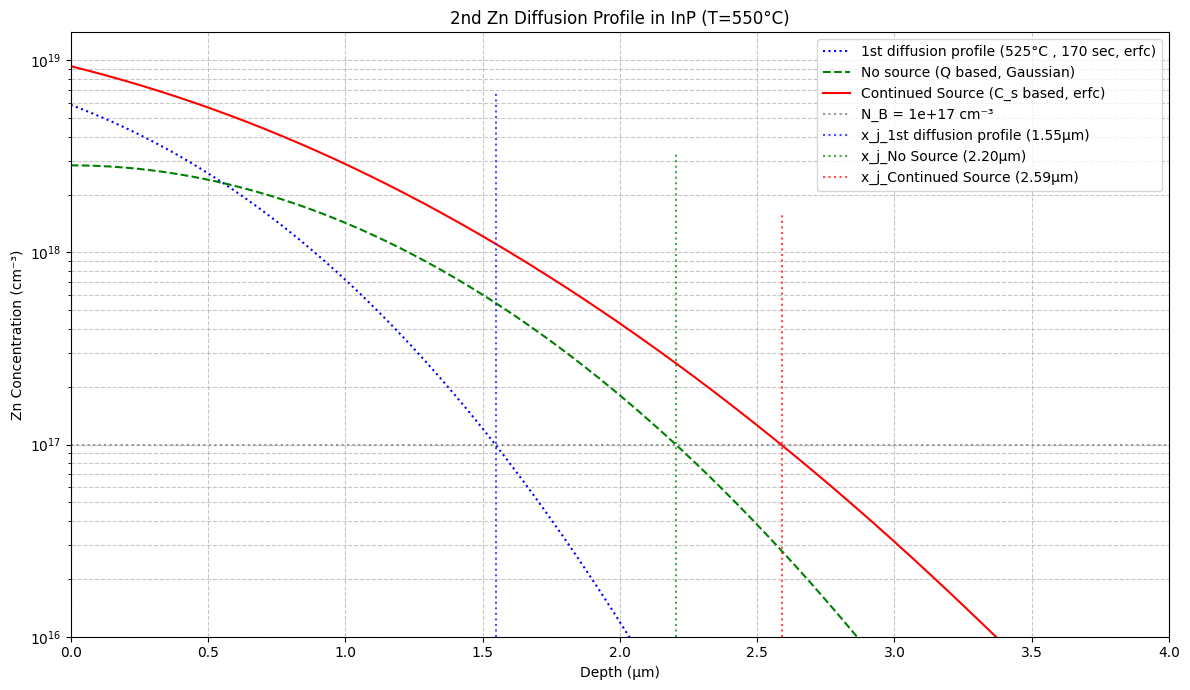

In [ ]:
# Cell 2: 2단계 확산 - 시나리오 1 (No source) 및 시나리오 2 (Continued Source)

# Cell 1에서 계산된 변수들이 현재 네임스페이스에 있어야 합니다.
# (Q_initial, t1_seconds, C_xt_1, x_microns, x_cm, N_B, x_j_um_1)

print("\n--- Cell 2: 시나리오 1 (Drive-in) 및 시나리오 2 (Continued Source) 실행 중 ---")

if 'Q_initial' not in locals() or 'C_xt_1' not in locals():
    print("오류: Cell 1을 먼저 실행하여 필요한 변수들을 준비해야 합니다.")
else:
    # --- 2단계 확산 시간 (t2) ---
    # 두 시나리오 모두 동일한 t2 시간을 사용한다고 가정 (비교를 위해)
    # 필요시 각 시나리오에 대해 다른 t2 값을 설정할 수 있습니다.

    C_s_2 = 9.311e18  # atoms/cm^3, at 550 celsius
    D_2 = 2.419e-11 # cm^2/s, at 550 celsius

    # --- 시나리오 1: No source (소스 제거 후 열처리) ---
    print(f"\n--- 시나리오 1: No source (t2 = {t2_seconds} sec) ---")
    denominator_gaussian = np.sqrt(np.pi * D_2 * t2_seconds)
    if denominator_gaussian == 0:
        C_xt_no= C_xt_1.copy()
        print("  No source 시간 (t2)이 0이므로, 프로파일은 초기 확산과 동일합니다.")
        surface_conc_no = C_xt_1[0]
    else:
        C_xt_no = (Q_initial / denominator_gaussian) * \
                        np.exp(-(x_cm**2) / (4 * D_2 * t2_seconds))
        surface_conc_no = C_xt_no[0]
    print(f"  - 예상 표면 농도: {surface_conc_no:.2e} atoms/cm³")

    idx_no_junction = np.where(C_xt_no <= N_B)[0]
    x_j_no_um = x_microns[idx_no_junction[0]] if len(idx_no_junction) > 0 else max_depth_um
    print(f"  - 접합 깊이 (x_j_no, N_B={N_B:.0e}): {x_j_no_um:.2f} µm")


    # FDM 파라미터
    # dx는 Cell 1의 x_cm 배열 간격 사용
    dx_cm = x_cm[1] - x_cm[0] # 공간 스텝 (균일하다고 가정)

    # dt 시간 스텝 (안정성 조건 D * dt / dx^2 <= 0.5 고려)
    # alpha = D_zn_in_inp * dt / dx_cm**2
    # dt <= 0.5 * dx_cm**2 / D_zn_in_inp
    # 안전하게 하기 위해 0.4 정도로 설정
    dt_seconds = 0.4 * (dx_cm**2) / D_2
    num_time_steps = int(t2_seconds / dt_seconds)
    if num_time_steps == 0 and t2_seconds > 0: # t2_seconds가 매우 작아서 num_time_steps가 0이 되는 경우 방지
        num_time_steps = 1
        dt_seconds = t2_seconds

    print(f"  FDM 파라미터:")
    print(f"    dx_cm: {dx_cm:.2e} cm")
    print(f"    dt_seconds: {dt_seconds:.2e} s (계산된 최적값 근처)")
    print(f"    num_time_steps for t2: {num_time_steps}")

    # 초기 농도 프로파일은 Cell 1의 C_xt_initial 사용
    C_fdm = np.copy(C_xt_1) # C_xt_initial은 t1 이후의 프로파일
    C_next_fdm = np.copy(C_fdm)

    alpha = D_2 * dt_seconds / (dx_cm**2)
    print(f"    Alpha (D*dt/dx^2): {alpha:.4f} (안정성을 위해 <= 0.5 권장)")
    if alpha > 0.5:
        print("    경고: Alpha 값이 0.5보다 큽니다. 수치적으로 불안정할 수 있습니다.")
        print("    x_points를 늘리거나 t2_secondary_diffusion_hours를 줄여보세요.")
        # 또는 dt_seconds를 더 작게 수동 조절

   # 시간 반복 (t2 동안)
    for step in range(num_time_steps):
        # 경계 조건: 표면 농도는 C_s_2로 유지
        C_next_fdm[0] = C_s_2
        # 내부 노드 계산
        for i in range(1, len(x_cm) - 1):
            C_next_fdm[i] = C_fdm[i] + alpha * (C_fdm[i+1] - 2*C_fdm[i] + C_fdm[i-1])
        # 맨 끝점 경계 조건 (Neumann: dC/dx = 0, 즉 변화 없음 또는 더 긴 영역 가정)
        C_next_fdm[-1] = C_next_fdm[-2] # 간단한 처리, 또는 C_fdm[-1] + alpha * (C_fdm[-2] - 2*C_fdm[-1] + C_fdm[-2]) 등
        C_fdm = np.copy(C_next_fdm)

    C_xt_continued_source_fdm = C_fdm

    print(f"  FDM 계산 후:")
    print(f"  - 표면 농도 (C_s_initial): {C_xt_continued_source_fdm[0]:.2e} atoms/cm³ (경계조건)")

    idx_continued_fdm_junction = np.where(C_xt_continued_source_fdm <= N_B)[0]
    x_j_continued_um = x_microns[idx_continued_fdm_junction[0]] if len(idx_continued_fdm_junction) > 0 else max_depth_um
    print(f"  - 접합 깊이 (x_j_continued_fdm, N_B={N_B:.0e}): {x_j_continued_um:.2f} µm")

    np.savetxt('diffusion_profiles.csv',
           np.c_[x_microns * 1e4, C_xt_1, C_xt_no, C_xt_continued_source_fdm],  # x_coords를 μm 단위로 변환
           delimiter=',',
           header='Depth(um),Profile_1st_Diffusion,Profile_2nd_No_Source,Profile_2nd_With_Source',
           comments='')  # comments=''로 설정하면 헤더 앞에 # 기호가 붙지 않음

    print("프로필이 'diffusion_profiles.csv' 파일로 저장되었습니다.")


    # --- 모든 결과 종합 비교 플로팅 ---
    plt.figure(figsize=(12, 7))

    # 1. 초기 확산 (Cell 1 결과)
    plt.semilogy(x_microns, C_xt_1,
                 label=f'1st diffusion profile (525°C , {t1_seconds} sec, erfc)',
                 linestyle=':', color='blue')

    # 2. 시나리오 1: No source
    no_label = f'No source (Q based, Gaussian)'
    plt.semilogy(x_microns, C_xt_no,
                 label=no_label,
                 linestyle='--', color='green')

    # 3. 시나리오 2: Continued Source
    continued_source_label = f'Continued Source (C_s based, erfc)'
    plt.semilogy(x_microns, C_xt_continued_source_fdm,
                 label=continued_source_label,
                 linestyle='-', color='red')

    # 배경 농도
    plt.axhline(y=N_B, color='grey', linestyle=':', alpha=0.8, label=f'N_B = {N_B:.0e} cm⁻³')

    # 접합 깊이 표시
    if x_j_um_1 < max_depth_um:
        plt.axvline(x=x_j_um_1, ymax=0.9, color='blue', linestyle=':', alpha=0.7,
                    label=f'x_j_1st diffusion profile ({x_j_um_1:.2f}µm)')
    if x_j_no_um < max_depth_um:
        plt.axvline(x=x_j_no_um, ymax=0.8, color='green', linestyle=':', alpha=0.7,
                    label=f'x_j_No Source ({x_j_no_um:.2f}µm)')
    if x_j_continued_um < max_depth_um:
        plt.axvline(x=x_j_continued_um, ymax=0.7, color='red', linestyle=':', alpha=0.7,
                    label=f'x_j_Continued Source ({x_j_continued_um:.2f}µm)')

    plt.xlabel('Depth (µm)')
    plt.ylabel('Zn Concentration (cm⁻³)')
    plt.title(f'2nd Zn Diffusion Profile in InP (T=550°C)')
    plt.legend(loc='upper right')
    plt.grid(True, which="both", ls="--", alpha=0.7)
    plt.ylim(bottom=max(1e16, N_B/10), top=C_s_2*1.5)
    plt.xlim(left=0, right=max_depth_um)
    plt.tight_layout()
    plt.show()